# BB84 QKD Parameters Optimization

## Fiber Lengths and n_X Values
Fiber lengths are created from 0 to 200 km in 0.1 km steps, resulting in 2001 unique fiber lengths. \
$n_X$ values are used ranging from $10^6$ to $10^{10}$, creating 5 unique values. \
Form all combinations of fiber lengths and $n_X$, resulting in 2001 $\times$ 5 = 10,005 combinations, which aligns with the aim to generate a large dataset.

## Optimization Process:
For each combination of fiber length $L$ and $n_X$, The parameters $\vec{p}$ = $ [ \mu_1, \mu_2, P_{\mu_1}, P_{\mu_2}, P_X ]$ are optimized using dual_annealing, which is a global optimization algorithm. \
The objective function is wrapped to evaluate the key rate for a specific combination of fiber length and $n_X$. 

## Parallelization:
joblib’s Parallel is used to run the optimization for all combinations in parallel, with 12 threads, making the process efficient. \
tqdm-joblib is also used to track progress visually. 

## Dataset Creation:
The results of the optimization ($e_1, e_2, e_3, e_4, n_X, R, p_{opt}$) are collected into a dataset. \
This dataset is saved to a file (training_dataset.json) for training a neural network. 




## Setup

### Framework Selection:JAX
Functional Programming: Simplify scientific computation and optimization workflows. \
Smaller Footprint: Ideal if the project doesn’t leverage TensorFlow’s broader ecosystem.

##### Key Considerations
For numerically intensive workloads (e.g., optimization tasks like QKD key rate calculations), JAX excels due to its lightweight functional paradigm.

##### Conclusion
Use JAX for performance-critical, purely numerical optimization tasks with minimal dependencies on machine learning frameworks.

## Imports

In [1]:
# Import necessary libraries
import os
import sys
import time
import json
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
from collections import defaultdict
from scipy.optimize import minimize, dual_annealing, differential_evolution, Bounds

# JAX imports
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.scipy.special import logsumexp, gamma
from jax.experimental import pjit
from jax.sharding import Mesh

# SciPy imports
from math import exp, factorial

# JAX configuration for double precision
jax.config.update("jax_enable_x64", True)

# Get the notebook's directory
notebook_dir = os.getcwd()
# Add parent directory to path
project_root = os.path.dirname(notebook_dir)
sys.path.append(project_root)

/Users/daai6ga1hou2/anaconda3/envs/qkd-training_set/lib/python3.9/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
print(jax.devices())

[CpuDevice(id=0)]


In [3]:
# pip install jax --upgrade s

## Experimental Parameters

In [4]:
# e_1
# Fiber lengths
Ls = jnp.linspace(1e-12, 200, 1000)  # Fiber lengths in km
L_BC = Ls
e_1 = L_BC / 100
    
#e_2
P_dc_value = 6*10**-7  # Dark count probability
Y_0 = P_dc_value
# 2.7*10** -7
# P_dc = 6 * 10 ** (-7)   # given in the paper, discussed with range from 10^-8 to 10^-5
e_2 = -jnp.log(Y_0)

# e_3
e_mis = 5 * 10 ** -3  # Misalignment error probability
# 0.026 
e_d = e_mis
e_3 = e_d * 100
e_mis = 5*1e-3 # given in the paper, discussed with range from 0 to 0.1 

# e_4
# Detected events
n_X_values = [10**6] #[10 ** s for s in range(4, 11)]  # Detected events
# n_X_values = jnp.array([10**s for s in range(6, 11)], dtype=jnp.int64)
N = jnp.array(n_X_values)
e_4 = jnp.log(N)

## Other Parameters

In [5]:
alpha = 0.2  # Attenuation coefficient (dB/km), given in the paper
eta_Bob = 0.1  # Detector efficiency, given in the paper
P_ap = 0  # After-pulse probability
f_EC = 1.16  # Error correction efficiency
# secutity error 
epsilon_sec = 1e-10 # is equal to kappa * secrecy length Kl, range around 1e-10 Scalar, as it is a single value throughout the calculations.
# correlation error
epsilon_cor = 1e-15 # given in the paper, discussed with range from 0 to 10e-10
# Dark count probability
n_event = 1  # for single photon event
# Misalignment error probability
# 4*1e-2          # given in the paper, discussed with range from 0 to 0.1
kappa = 1e-15           # given in the paper
f_EC = 1.16             # given in the paper, range around 1.1


## Optimal Paramters

In [6]:
def optimal_parameters(params):
    mu_1, mu_2, P_mu_1, P_mu_2, P_X_value = params
    mu_3 = 2e-4
    P_mu_3 = 1 - P_mu_1 - P_mu_2
    P_Z_value = 1 - P_X_value
    mu_k_values = jnp.array([mu_1, mu_2, mu_3])
    return params, mu_3, P_mu_3, P_Z_value, mu_k_values

## Functions

The calculate_factorial function provided uses the gamma function to compute the factorial of a number  n . This is mathematically correct because the gamma function  \Gamma(n+1)  is equivalent to the factorial  n!  for non-negative integers  n .

## Mathematical Background
The gamma function is defined as:
$\Gamma(x) = \int_0^\infty t^{x-1} e^{-t} \, dt$ \
For positive integers, the gamma function satisfies the relationship: \
$\Gamma(n + 1) = n!$
\
JAX does not have a built-in factorial function, but it does support the gamma function. This makes the approach valid and compatible with JAX for automatic differentiation and JIT compilation.

In [7]:
from QKD_Functions import (
calculate_factorial,
calculate_tau_n,
    calculate_eta_ch,
    calculate_eta_sys,
    calculate_D_mu_k,
    calculate_n_X_total,
    calculate_N,
    calculate_n_Z_total,
    calculate_e_mu_k,
    calculate_e_obs,
    calculate_h,
    calculate_lambda_EC,
    calculate_sqrt_term,
    calculate_tau_n,
    calculate_n_pm, 
    calculate_S_0,
    calculate_S_1,
    calculate_m_mu_k,
    calculate_m_pm,
    calculate_v_1,
    calculate_gamma,
    calculate_Phi,
    calculate_LastTwoTerm,
    calculate_l,
    calculate_R,
    experimental_parameters,
    other_parameters,
    calculate_key_rates_and_metrics,
    penalty, 
    objective,
)

In [8]:
# Initialize dataset storage
categorized_dataset = {n_X: [] for n_X in n_X_values}

# Initial guess and bounds
initial_guess = np.array([0.54, 0.375, 0.16, 0.775, 0.83])
bounds = [
    (4e-4, 0.9),  
    (2e-4, 0.5),  
    (1e-12, 1.0 - 1e-12),  
    (1e-12, 1.0 - 1e-12),  
    (1e-12, 1.0 - 1e-12),  
]

# Define L values
L_values = np.linspace(0, 200, 100)
n_X_values = [500000000] # np.logspace(4, 9, 6)  # Logarithmically spaced values from 10^4 to 10^9

In [9]:
import numpy as np
from scipy.optimize import dual_annealing, minimize
from tqdm import tqdm
import concurrent.futures
import logging
import json
import time

In [10]:
# Global variables
x0 = initial_guess.copy()  # Store the last used initial guess
last_valid_x0 = initial_guess.copy()  # Store the last valid parameters

In [11]:


# Setup basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def optimize_single_instance(L, n_X, bounds, initial_guess, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event):
    """Optimize key rate for a given fiber length L and fixed n_X."""
    global x0, last_valid_x0
    print(f"\n--- [DEBUG] Starting optimization for L={L} km ---")

    try:
        def wrapped_objective(params):
            key_rate = objective(params, L, n_X, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)[0]
            return  -max(0, key_rate)

        print(f"🔵 Initial Guess for L={L}: {x0}")

        # Global optimization
        # Perform global optimization
        global_result = dual_annealing(
            func=wrapped_objective,
            bounds=bounds,
            initial_temp=20,  
            restart_temp_ratio=1e-8,  
            visit=2.0,  
            accept=-15.0,
            x0=x0
        )
        # Local refinement
        local_result = minimize(
            fun=wrapped_objective,
            x0=global_result.x,
            method='Nelder-Mead',
            options={'maxiter': 10000, 'xatol': 1e-10, 'fatol': 1e-10}
        )

        optimized_params = local_result.x
        optimized_params = np.clip(optimized_params,  
                           [b[0] for b in bounds], 
                           [b[1] for b in bounds])
        optimized_key_rate = -local_result.fun

        print(f"✅ Final Optimized Parameters for L={L} km: {optimized_params}")
        print(f"✅ Final Optimized Key Rate for L={L} km: {optimized_key_rate}")

        # Update x0 with the latest optimized parameters
        x0 = optimized_params.copy()

        # Check if parameters are within bounds
        out_of_bounds_flags = [param < b[0] or param > b[1] for param, b in zip(optimized_params, bounds)]
        out_of_bounds = any(out_of_bounds_flags)  

        if not out_of_bounds:
            return L, n_X, optimized_key_rate, optimized_params, optimized_params.copy()  
        else:
            print(f"⚠️ Parameters out of bounds for L={L} km, but keeping best parameters seen so far.")
            return L, n_X, optimized_key_rate, optimized_params, x0  

    except Exception as e:
        print(f"❌ Error at L={L}: {e}")
        return L, n_X, float('nan'), [float('nan')] * len(bounds), x0
    
def submit_in_batches(executor, L_values, n_X_values, bounds, initial_guess, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event, batch_size=32 ):
    all_results = []
    tasks = [(L, n_X) for L in L_values for n_X in n_X_values]
    total = len(tasks)
    with tqdm(total=total, desc="Optimizing") as pbar:
        for i in range(0, total, batch_size):
            batch = tasks[i:i + batch_size]
            futures = [executor.submit(optimize_single_instance, L, n_X, bounds, initial_guess, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event) for L, n_X in batch]
            for future in concurrent.futures.as_completed(futures):
                result = future.result()
                all_results.append(result)
                pbar.update(1)
    return all_results

if __name__ == '__main__':
    # Define constants and bounds
    bounds = [(4e-4, 0.9), (2e-4, 0.5), (1e-12, 1.0 - 1e-12), (1e-12, 1.0 - 1e-12), (1e-12, 1.0 - 1e-12)]
    initial_guess = np.array([0.54, 0.375, 0.16, 0.775, 0.83])
    L_values = np.linspace(0, 200, 100)
    n_X_values = [500000000]  # Detected events

    # Optimization parameters
    alpha = 0.2
    eta_Bob = 0.1
    P_dc_value = 1e-5
    epsilon_sec = 1e-10
    epsilon_cor = 1e-15
    f_EC = 1.16
    e_mis = 0.01
    P_ap = 0
    n_event = 1

    # Run optimization using ThreadPoolExecutor
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        all_results_sorted = submit_in_batches(executor, L_values, n_X_values, bounds, initial_guess, alpha, eta_Bob, P_dc_value, epsilon_sec, epsilon_cor, f_EC, e_mis, P_ap, n_event)

    # Generate and save dataset
    dataset = [{
        "fiber_length": float(L),
        "n_X": int(n_X),
        "key_rate": float(key_rate),
        "optimized_parameters": { "mu_1": float(params[0]), "mu_2": float(params[1]), "P_mu_1": float(params[2]), "P_mu_2": float(params[3]), "P_X_value": float(params[4]) },
        "initial_guess": { "mu_1": float(init_guess[0]), "mu_2": float(init_guess[1]), "P_mu_1": float(init_guess[2]), "P_mu_2": float(init_guess[3]), "P_X_value": float(init_guess[4]) }
    } for L, n_X, key_rate, params, init_guess in all_results_sorted]

    timestamp = time.strftime("%Y%m%d_%H%M%S")
    filename = f'qkd_optimization_results_{timestamp}.json'
    with open(filename, 'w') as f:
        json.dump(dataset, f, indent=2)

    # Print dataset summary
    print("\nDataset Summary:")
    print(f"Total Entries: {len(dataset)}")
    print(f"Fiber Length Range: {dataset[0]['fiber_length']} km to {dataset[-1]['fiber_length']} km")
    print(f"n_X Values: {', '.join(map(str, n_X_values))}")

Optimizing:   0%|          | 0/100 [00:00<?, ?it/s]


--- [DEBUG] Starting optimization for L=0.0 km ---
🔵 Initial Guess for L=0.0: [0.54  0.375 0.16  0.775 0.83 ]

--- [DEBUG] Starting optimization for L=2.0202020202020203 km ---
🔵 Initial Guess for L=2.0202020202020203: [0.54  0.375 0.16  0.775 0.83 ]

--- [DEBUG] Starting optimization for L=4.040404040404041 km ---
🔵 Initial Guess for L=4.040404040404041: [0.54  0.375 0.16  0.775 0.83 ]

--- [DEBUG] Starting optimization for L=6.0606060606060606 km ---
🔵 Initial Guess for L=6.0606060606060606: [0.54  0.375 0.16  0.775 0.83 ]


Optimizing:   2%|▏         | 2/100 [00:15<10:32,  6.45s/it]

✅ Final Optimized Parameters for L=6.0606060606060606 km: [0.49279999 0.35680402 0.18354589 0.77075954 0.86228818]
✅ Final Optimized Key Rate for L=6.0606060606060606 km: 0.007598768212607877

--- [DEBUG] Starting optimization for L=8.080808080808081 km ---
🔵 Initial Guess for L=8.080808080808081: [0.49279999 0.35680402 0.18354589 0.77075954 0.86228818]
✅ Final Optimized Parameters for L=4.040404040404041 km: [0.49404231 0.3579824  0.183035   0.77129059 0.86238234]
✅ Final Optimized Key Rate for L=4.040404040404041 km: 0.008371077770039552

--- [DEBUG] Starting optimization for L=10.101010101010102 km ---
🔵 Initial Guess for L=10.101010101010102: [0.49404231 0.3579824  0.183035   0.77129059 0.86238234]
✅ Final Optimized Parameters for L=2.0202020202020203 km: [0.49546786 0.359267   0.18251787 0.77183443 0.86247728]
✅ Final Optimized Key Rate for L=2.0202020202020203 km: 0.009222937015777859

--- [DEBUG] Starting optimization for L=12.121212121212121 km ---
🔵 Initial Guess for L=12.1212

Optimizing:   4%|▍         | 4/100 [00:15<03:54,  2.44s/it]

✅ Final Optimized Parameters for L=0.0 km: [0.49709168 0.36067042 0.18198917 0.77239686 0.86257401]
✅ Final Optimized Key Rate for L=0.0 km: 0.010162991029496716

--- [DEBUG] Starting optimization for L=14.141414141414142 km ---
🔵 Initial Guess for L=14.141414141414142: [0.49709168 0.36067042 0.18198917 0.77239686 0.86257401]


Optimizing:   5%|▌         | 5/100 [00:30<09:47,  6.18s/it]

✅ Final Optimized Parameters for L=8.080808080808081 km: [0.49172782 0.35572049 0.18405467 0.770237   0.86219393]
✅ Final Optimized Key Rate for L=8.080808080808081 km: 0.006898273384589027

--- [DEBUG] Starting optimization for L=16.161616161616163 km ---
🔵 Initial Guess for L=16.161616161616163: [0.49172782 0.35572049 0.18405467 0.770237   0.86219393]


Optimizing:   7%|▋         | 7/100 [00:30<04:49,  3.12s/it]

✅ Final Optimized Parameters for L=10.101010101010102 km: [0.49081467 0.35472151 0.1845669  0.76971689 0.86209858]
✅ Final Optimized Key Rate for L=10.101010101010102 km: 0.006262662462901468

--- [DEBUG] Starting optimization for L=18.181818181818183 km ---
🔵 Initial Guess for L=18.181818181818183: [0.49081467 0.35472151 0.1845669  0.76971689 0.86209858]
✅ Final Optimized Parameters for L=12.121212121212121 km: [0.4900506  0.35379752 0.18508725 0.76919449 0.86200124]
✅ Final Optimized Key Rate for L=12.121212121212121 km: 0.005685716699409829

--- [DEBUG] Starting optimization for L=20.202020202020204 km ---
🔵 Initial Guess for L=20.202020202020204: [0.4900506  0.35379752 0.18508725 0.76919449 0.86200124]


Optimizing:   8%|▊         | 8/100 [00:31<03:26,  2.24s/it]

✅ Final Optimized Parameters for L=14.141414141414142 km: [0.48942737 0.35293989 0.18562095 0.76866426 0.86190088]
✅ Final Optimized Key Rate for L=14.141414141414142 km: 0.005161849226329055

--- [DEBUG] Starting optimization for L=22.222222222222225 km ---
🔵 Initial Guess for L=22.222222222222225: [0.48942737 0.35293989 0.18562095 0.76866426 0.86190088]


Optimizing:   9%|▉         | 9/100 [00:45<08:47,  5.80s/it]

✅ Final Optimized Parameters for L=16.161616161616163 km: [0.48893765 0.35214072 0.1861732  0.76812081 0.86179651]
✅ Final Optimized Key Rate for L=16.161616161616163 km: 0.004686035004579672

--- [DEBUG] Starting optimization for L=24.242424242424242 km ---
🔵 Initial Guess for L=24.242424242424242: [0.48893765 0.35214072 0.1861732  0.76812081 0.86179651]


Optimizing:  10%|█         | 10/100 [00:45<06:27,  4.31s/it]

✅ Final Optimized Parameters for L=18.181818181818183 km: [0.48857561 0.35139259 0.18674969 0.76755831 0.86168707]
✅ Final Optimized Key Rate for L=18.181818181818183 km: 0.004253749468185264

--- [DEBUG] Starting optimization for L=26.262626262626263 km ---
🔵 Initial Guess for L=26.262626262626263: [0.48857561 0.35139259 0.18674969 0.76755831 0.86168707]


Optimizing:  11%|█         | 11/100 [00:46<04:35,  3.09s/it]

✅ Final Optimized Parameters for L=20.202020202020204 km: [0.48833617 0.35068869 0.18735631 0.76697075 0.86157137]
✅ Final Optimized Key Rate for L=20.202020202020204 km: 0.003860914646643796

--- [DEBUG] Starting optimization for L=28.282828282828284 km ---
🔵 Initial Guess for L=28.282828282828284: [0.48833617 0.35068869 0.18735631 0.76697075 0.86157137]


Optimizing:  12%|█▏        | 12/100 [00:46<03:20,  2.28s/it]

✅ Final Optimized Parameters for L=22.222222222222225 km: [0.48821553 0.35002273 0.18799951 0.76635151 0.86144825]
✅ Final Optimized Key Rate for L=22.222222222222225 km: 0.003503851736983949

--- [DEBUG] Starting optimization for L=30.303030303030305 km ---
🔵 Initial Guess for L=30.303030303030305: [0.48821553 0.35002273 0.18799951 0.76635151 0.86144825]


Optimizing:  13%|█▎        | 13/100 [01:00<08:12,  5.66s/it]

✅ Final Optimized Parameters for L=24.242424242424242 km: [0.48821039 0.34938871 0.18868583 0.76569389 0.86131636]
✅ Final Optimized Key Rate for L=24.242424242424242 km: 0.003179239254953378

--- [DEBUG] Starting optimization for L=32.323232323232325 km ---
🔵 Initial Guess for L=32.323232323232325: [0.48821039 0.34938871 0.18868583 0.76569389 0.86131636]


Optimizing:  14%|█▍        | 14/100 [01:01<06:10,  4.31s/it]

✅ Final Optimized Parameters for L=26.262626262626263 km: [0.48831858 0.34878103 0.189423   0.76499005 0.86117431]
✅ Final Optimized Key Rate for L=26.262626262626263 km: 0.0028840760261820424

--- [DEBUG] Starting optimization for L=34.343434343434346 km ---
🔵 Initial Guess for L=34.343434343434346: [0.48831858 0.34878103 0.189423   0.76499005 0.86117431]


Optimizing:  15%|█▌        | 15/100 [01:01<04:27,  3.14s/it]

✅ Final Optimized Parameters for L=28.282828282828284 km: [0.48853838 0.34819419 0.19021902 0.76423186 0.86102051]
✅ Final Optimized Key Rate for L=28.282828282828284 km: 0.0026156483878897003

--- [DEBUG] Starting optimization for L=36.36363636363637 km ---
🔵 Initial Guess for L=36.36363636363637: [0.48853838 0.34819419 0.19021902 0.76423186 0.86102051]


Optimizing:  16%|█▌        | 16/100 [01:02<03:15,  2.32s/it]

✅ Final Optimized Parameters for L=30.303030303030305 km: [0.48886896 0.34762324 0.19108273 0.76341022 0.86085327]
✅ Final Optimized Key Rate for L=30.303030303030305 km: 0.0023715010635682195

--- [DEBUG] Starting optimization for L=38.38383838383839 km ---
🔵 Initial Guess for L=38.38383838383839: [0.48886896 0.34762324 0.19108273 0.76341022 0.86085327]


Optimizing:  17%|█▋        | 17/100 [01:15<07:39,  5.53s/it]

✅ Final Optimized Parameters for L=32.323232323232325 km: [0.48930982 0.34706315 0.19202433 0.7625148  0.86067058]
✅ Final Optimized Key Rate for L=32.323232323232325 km: 0.002149411250179073

--- [DEBUG] Starting optimization for L=40.40404040404041 km ---
🔵 Initial Guess for L=40.40404040404041: [0.48930982 0.34706315 0.19202433 0.7625148  0.86067058]


Optimizing:  18%|█▊        | 18/100 [01:16<05:54,  4.32s/it]

✅ Final Optimized Parameters for L=34.343434343434346 km: [0.48986142 0.34650912 0.19305429 0.76153484 0.86047047]
✅ Final Optimized Key Rate for L=34.343434343434346 km: 0.0019473655223017881

--- [DEBUG] Starting optimization for L=42.42424242424243 km ---
🔵 Initial Guess for L=42.42424242424243: [0.48986142 0.34650912 0.19305429 0.76153484 0.86047047]


Optimizing:  19%|█▉        | 19/100 [01:17<04:18,  3.19s/it]

✅ Final Optimized Parameters for L=36.36363636363637 km: [0.49052393 0.34595645 0.19418452 0.76045817 0.86025038]
✅ Final Optimized Key Rate for L=36.36363636363637 km: 0.0017635392124451708

--- [DEBUG] Starting optimization for L=44.44444444444445 km ---
🔵 Initial Guess for L=44.44444444444445: [0.49052393 0.34595645 0.19418452 0.76045817 0.86025038]


Optimizing:  20%|██        | 20/100 [01:17<03:11,  2.40s/it]

✅ Final Optimized Parameters for L=38.38383838383839 km: [0.49129887 0.34540052 0.1954292  0.75927026 0.86000769]
✅ Final Optimized Key Rate for L=38.38383838383839 km: 0.0015962779730850703

--- [DEBUG] Starting optimization for L=46.46464646464647 km ---
🔵 Initial Guess for L=46.46464646464647: [0.49129887 0.34540052 0.1954292  0.75927026 0.86000769]


Optimizing:  21%|██        | 21/100 [01:30<07:07,  5.42s/it]

✅ Final Optimized Parameters for L=40.40404040404041 km: [0.48544246 0.34506594 0.18875763 0.75825475 0.86138146]
✅ Final Optimized Key Rate for L=40.40404040404041 km: 0.001444677290286368

--- [DEBUG] Starting optimization for L=48.484848484848484 km ---
🔵 Initial Guess for L=48.484848484848484: [0.48544246 0.34506594 0.18875763 0.75825475 0.86138146]


Optimizing:  22%|██▏       | 22/100 [01:31<05:37,  4.33s/it]

✅ Final Optimized Parameters for L=42.42424242424243 km: [0.48547666 0.34485359 0.18942488 0.75751182 0.86114782]
✅ Final Optimized Key Rate for L=42.42424242424243 km: 0.001308244409958405

--- [DEBUG] Starting optimization for L=50.505050505050505 km ---
🔵 Initial Guess for L=50.505050505050505: [0.48547666 0.34485359 0.18942488 0.75751182 0.86114782]


Optimizing:  23%|██▎       | 23/100 [01:32<04:09,  3.24s/it]

✅ Final Optimized Parameters for L=44.44444444444445 km: [0.485565   0.34465463 0.19014255 0.75671327 0.86089218]
✅ Final Optimized Key Rate for L=44.44444444444445 km: 0.001184066425488649

--- [DEBUG] Starting optimization for L=52.525252525252526 km ---
🔵 Initial Guess for L=52.525252525252526: [0.485565   0.34465463 0.19014255 0.75671327 0.86089218]


Optimizing:  24%|██▍       | 24/100 [01:33<03:06,  2.45s/it]

✅ Final Optimized Parameters for L=46.46464646464647 km: [0.48570774 0.34446635 0.19091602 0.75585299 0.86061209]
✅ Final Optimized Key Rate for L=46.46464646464647 km: 0.0010710386943648524

--- [DEBUG] Starting optimization for L=54.54545454545455 km ---
🔵 Initial Guess for L=54.54545454545455: [0.48570774 0.34446635 0.19091602 0.75585299 0.86061209]


Optimizing:  25%|██▌       | 25/100 [01:45<06:36,  5.29s/it]

✅ Final Optimized Parameters for L=48.484848484848484 km: [0.48590558 0.34428584 0.19175168 0.75492412 0.86030481]
✅ Final Optimized Key Rate for L=48.484848484848484 km: 0.0009681579859538508

--- [DEBUG] Starting optimization for L=56.56565656565657 km ---
🔵 Initial Guess for L=56.56565656565657: [0.48590558 0.34428584 0.19175168 0.75492412 0.86030481]


Optimizing:  26%|██▌       | 26/100 [01:47<05:20,  4.33s/it]

✅ Final Optimized Parameters for L=50.505050505050505 km: [0.4861594  0.34411075 0.19265493 0.75392052 0.85996717]
✅ Final Optimized Key Rate for L=50.505050505050505 km: 0.0008745129462989966

--- [DEBUG] Starting optimization for L=58.58585858585859 km ---
🔵 Initial Guess for L=58.58585858585859: [0.4861594  0.34411075 0.19265493 0.75392052 0.85996717]


Optimizing:  27%|██▋       | 27/100 [01:48<04:01,  3.30s/it]

✅ Final Optimized Parameters for L=52.525252525252526 km: [0.48647075 0.34393799 0.19363102 0.75283615 0.8595959 ]
✅ Final Optimized Key Rate for L=52.525252525252526 km: 0.00078927550139552

--- [DEBUG] Starting optimization for L=60.60606060606061 km ---
🔵 Initial Guess for L=60.60606060606061: [0.48647075 0.34393799 0.19363102 0.75283615 0.8595959 ]


Optimizing:  28%|██▊       | 28/100 [01:48<02:58,  2.49s/it]

✅ Final Optimized Parameters for L=54.54545454545455 km: [0.48684124 0.34376457 0.1946888  0.75166156 0.85918681]
✅ Final Optimized Key Rate for L=54.54545454545455 km: 0.0007116930997559293

--- [DEBUG] Starting optimization for L=62.62626262626263 km ---
🔵 Initial Guess for L=62.62626262626263: [0.48684124 0.34376457 0.1946888  0.75166156 0.85918681]


Optimizing:  29%|██▉       | 29/100 [01:59<06:02,  5.11s/it]

✅ Final Optimized Parameters for L=56.56565656565657 km: [0.48727277 0.34358714 0.19583342 0.75039081 0.85873589]
✅ Final Optimized Key Rate for L=56.56565656565657 km: 0.0006410817066644446


Optimizing:  30%|███       | 30/100 [02:01<04:43,  4.04s/it]

✅ Final Optimized Parameters for L=58.58585858585859 km: [0.4877683  0.34340243 0.19707412 0.74901375 0.85823801]
✅ Final Optimized Key Rate for L=58.58585858585859 km: 0.0005768194725774274


Optimizing:  31%|███       | 31/100 [02:01<03:22,  2.94s/it]

✅ Final Optimized Parameters for L=60.60606060606061 km: [0.48833015 0.34320664 0.1984174  0.74752284 0.85768768]
✅ Final Optimized Key Rate for L=60.60606060606061 km: 0.0005183410069273648
✅ Final Optimized Parameters for L=62.62626262626263 km: [0.48896152 0.34299556 0.1998716  0.74590891 0.85707854]
✅ Final Optimized Key Rate for L=62.62626262626263 km: 0.00046513219627865304

--- [DEBUG] Starting optimization for L=64.64646464646465 km ---
🔵 Initial Guess for L=64.64646464646465: [0.48896152 0.34299556 0.1998716  0.74590891 0.85707854]

--- [DEBUG] Starting optimization for L=66.66666666666667 km ---
🔵 Initial Guess for L=66.66666666666667: [0.48896152 0.34299556 0.1998716  0.74590891 0.85707854]

--- [DEBUG] Starting optimization for L=68.68686868686869 km ---
🔵 Initial Guess for L=68.68686868686869: [0.48896152 0.34299556 0.1998716  0.74590891 0.85707854]

--- [DEBUG] Starting optimization for L=70.70707070707071 km ---
🔵 Initial Guess for L=70.70707070707071: [0.48896152 0.3429

Optimizing:  33%|███▎      | 33/100 [02:16<05:36,  5.02s/it]

✅ Final Optimized Parameters for L=64.64646464646465 km: [0.48966607 0.34276455 0.20144609 0.74416149 0.85640323]
✅ Final Optimized Key Rate for L=64.64646464646465 km: 0.0004167255125393616

--- [DEBUG] Starting optimization for L=72.72727272727273 km ---
🔵 Initial Guess for L=72.72727272727273: [0.48966607 0.34276455 0.20144609 0.74416149 0.85640323]


Optimizing:  36%|███▌      | 36/100 [02:17<02:27,  2.30s/it]

✅ Final Optimized Parameters for L=66.66666666666667 km: [0.49044727 0.34250892 0.20314816 0.74227201 0.85565359]
✅ Final Optimized Key Rate for L=66.66666666666667 km: 0.0003726957628818599

--- [DEBUG] Starting optimization for L=74.74747474747475 km ---
🔵 Initial Guess for L=74.74747474747475: [0.49044727 0.34250892 0.20314816 0.74227201 0.85565359]
✅ Final Optimized Parameters for L=68.68686868686869 km: [0.49130877 0.34222268 0.20498903 0.74022818 0.85481973]
✅ Final Optimized Key Rate for L=68.68686868686869 km: 0.00033265623828464133

--- [DEBUG] Starting optimization for L=76.76767676767678 km ---
🔵 Initial Guess for L=76.76767676767678: [0.49130877 0.34222268 0.20498903 0.74022818 0.85481973]
✅ Final Optimized Parameters for L=70.70707070707071 km: [0.49225531 0.34190051 0.20697593 0.73802119 0.85389071]
✅ Final Optimized Key Rate for L=70.70707070707071 km: 0.0002962552222708313

--- [DEBUG] Starting optimization for L=78.7878787878788 km ---
🔵 Initial Guess for L=78.78787878

Optimizing:  37%|███▋      | 37/100 [02:31<05:14,  4.99s/it]

✅ Final Optimized Parameters for L=72.72727272727273 km: [0.49329026 0.34153521 0.20911912 0.73563925 0.85285304]
✅ Final Optimized Key Rate for L=72.72727272727273 km: 0.0002631728255927843

--- [DEBUG] Starting optimization for L=80.80808080808082 km ---
🔵 Initial Guess for L=80.80808080808082: [0.49329026 0.34153521 0.20911912 0.73563925 0.85285304]


Optimizing:  38%|███▊      | 38/100 [02:32<04:05,  3.95s/it]

✅ Final Optimized Parameters for L=74.74747474747475 km: [0.48837021 0.34217426 0.21185548 0.72623552 0.85051636]
✅ Final Optimized Key Rate for L=74.74747474747475 km: 0.00023342134888782956

--- [DEBUG] Starting optimization for L=82.82828282828284 km ---
🔵 Initial Guess for L=82.82828282828284: [0.48837021 0.34217426 0.21185548 0.72623552 0.85051636]


Optimizing:  39%|███▉      | 39/100 [02:32<03:03,  3.01s/it]

✅ Final Optimized Parameters for L=76.76767676767678 km: [0.48804231 0.34236695 0.21358172 0.72392138 0.84935278]
✅ Final Optimized Key Rate for L=76.76767676767678 km: 0.00020648177953488521

--- [DEBUG] Starting optimization for L=84.84848484848486 km ---
🔵 Initial Guess for L=84.84848484848486: [0.48804231 0.34236695 0.21358172 0.72392138 0.84935278]
✅ Final Optimized Parameters for L=78.7878787878788 km: [0.48764407 0.34256296 0.21542675 0.72143586 0.84804208]
✅ Final Optimized Key Rate for L=78.7878787878788 km: 0.0001820399821057155

--- [DEBUG] Starting optimization for L=86.86868686868688 km ---
🔵 Initial Guess for L=86.86868686868688: [0.48764407 0.34256296 0.21542675 0.72143586 0.84804208]


Optimizing:  41%|████      | 41/100 [02:46<04:35,  4.66s/it]

✅ Final Optimized Parameters for L=80.80808080808082 km: [0.48716047 0.34275898 0.21740313 0.71876157 0.84655985]
✅ Final Optimized Key Rate for L=80.80808080808082 km: 0.0001598792669776002

--- [DEBUG] Starting optimization for L=88.8888888888889 km ---
🔵 Initial Guess for L=88.8888888888889: [0.48716047 0.34275898 0.21740313 0.71876157 0.84655985]


Optimizing:  42%|████▏     | 42/100 [02:47<03:43,  3.85s/it]

✅ Final Optimized Parameters for L=82.82828282828284 km: [0.48657581 0.34295266 0.21952406 0.71588026 0.84487638]
✅ Final Optimized Key Rate for L=82.82828282828284 km: 0.00013980258076732197

--- [DEBUG] Starting optimization for L=90.90909090909092 km ---
🔵 Initial Guess for L=90.90909090909092: [0.48657581 0.34295266 0.21952406 0.71588026 0.84487638]


Optimizing:  44%|████▍     | 44/100 [02:48<02:05,  2.24s/it]

✅ Final Optimized Parameters for L=84.84848484848486 km: [0.48587053 0.34314006 0.22180853 0.71276763 0.8429546 ]
✅ Final Optimized Key Rate for L=84.84848484848486 km: 0.00012163077155913017

--- [DEBUG] Starting optimization for L=92.92929292929294 km ---
🔵 Initial Guess for L=92.92929292929294: [0.48587053 0.34314006 0.22180853 0.71276763 0.8429546 ]
✅ Final Optimized Parameters for L=86.86868686868688 km: [0.48502228 0.34331726 0.22428508 0.70938936 0.84074773]
✅ Final Optimized Key Rate for L=86.86868686868688 km: 0.0001052010272446174

--- [DEBUG] Starting optimization for L=94.94949494949496 km ---
🔵 Initial Guess for L=94.94949494949496: [0.48502228 0.34331726 0.22428508 0.70938936 0.84074773]


Optimizing:  45%|████▌     | 45/100 [03:01<04:48,  5.24s/it]

✅ Final Optimized Parameters for L=88.8888888888889 km: [0.48400542 0.34348029 0.22698694 0.70570592 0.83819601]
✅ Final Optimized Key Rate for L=88.8888888888889 km: 9.036547771822914e-05

--- [DEBUG] Starting optimization for L=96.96969696969697 km ---
🔵 Initial Guess for L=96.96969696969697: [0.48400542 0.34348029 0.22698694 0.70570592 0.83819601]


Optimizing:  46%|████▌     | 46/100 [03:02<03:44,  4.16s/it]

✅ Final Optimized Parameters for L=90.90909090909092 km: [0.48278912 0.34362433 0.22996528 0.70165931 0.83522111]
✅ Final Optimized Key Rate for L=90.90909090909092 km: 7.698995607865817e-05

--- [DEBUG] Starting optimization for L=98.98989898989899 km ---
🔵 Initial Guess for L=98.98989898989899: [0.48278912 0.34362433 0.22996528 0.70165931 0.83522111]


Optimizing:  47%|████▋     | 47/100 [03:03<02:43,  3.09s/it]

✅ Final Optimized Parameters for L=92.92929292929294 km: [0.48133714 0.34374459 0.23329128 0.69717198 0.83171846]
✅ Final Optimized Key Rate for L=92.92929292929294 km: 6.495292030479689e-05

--- [DEBUG] Starting optimization for L=101.01010101010101 km ---
🔵 Initial Guess for L=101.01010101010101: [0.48133714 0.34374459 0.23329128 0.69717198 0.83171846]


Optimizing:  48%|████▊     | 48/100 [03:03<01:57,  2.26s/it]

✅ Final Optimized Parameters for L=94.94949494949496 km: [0.43880036 0.3248907  0.39656017 0.46535902 0.76032037]
✅ Final Optimized Key Rate for L=94.94949494949496 km: 5.572695176677017e-05

--- [DEBUG] Starting optimization for L=103.03030303030303 km ---
🔵 Initial Guess for L=103.03030303030303: [0.43880036 0.3248907  0.39656017 0.46535902 0.76032037]


Optimizing:  49%|████▉     | 49/100 [03:15<04:23,  5.16s/it]

✅ Final Optimized Parameters for L=96.96969696969697 km: [0.4372233  0.32089135 0.41047517 0.45323627 0.75575202]
✅ Final Optimized Key Rate for L=96.96969696969697 km: 4.814035249092136e-05

--- [DEBUG] Starting optimization for L=105.05050505050505 km ---
🔵 Initial Guess for L=105.05050505050505: [0.4372233  0.32089135 0.41047517 0.45323627 0.75575202]


Optimizing:  50%|█████     | 50/100 [03:17<03:26,  4.14s/it]

✅ Final Optimized Parameters for L=98.98989898989899 km: [0.43551742 0.316305   0.42618104 0.43950864 0.7505083 ]
✅ Final Optimized Key Rate for L=98.98989898989899 km: 4.131934157171627e-05

--- [DEBUG] Starting optimization for L=107.07070707070707 km ---
🔵 Initial Guess for L=107.07070707070707: [0.43551742 0.316305   0.42618104 0.43950864 0.7505083 ]


Optimizing:  52%|█████▏    | 52/100 [03:17<01:44,  2.18s/it]

✅ Final Optimized Parameters for L=101.01010101010101 km: [0.43369107 0.31102522 0.44391893 0.42396066 0.744446  ]
✅ Final Optimized Key Rate for L=101.01010101010101 km: 3.5200230401316015e-05

--- [DEBUG] Starting optimization for L=109.0909090909091 km ---
🔵 Initial Guess for L=109.0909090909091: [0.43369107 0.31102522 0.44391893 0.42396066 0.744446  ]
✅ Final Optimized Parameters for L=103.03030303030303 km: [0.43176233 0.30492284 0.46392746 0.40638527 0.73738186]
✅ Final Optimized Key Rate for L=103.03030303030303 km: 2.972536090963064e-05

--- [DEBUG] Starting optimization for L=111.11111111111111 km ---
🔵 Initial Guess for L=111.11111111111111: [0.43176233 0.30492284 0.46392746 0.40638527 0.73738186]


Optimizing:  53%|█████▎    | 53/100 [03:29<03:54,  4.99s/it]

✅ Final Optimized Parameters for L=105.05050505050505 km: [0.42976123 0.29783793 0.48644239 0.38658226 0.72907664]
✅ Final Optimized Key Rate for L=105.05050505050505 km: 2.4842664104672327e-05

--- [DEBUG] Starting optimization for L=113.13131313131314 km ---
🔵 Initial Guess for L=113.13131313131314: [0.42976123 0.29783793 0.48644239 0.38658226 0.72907664]


Optimizing:  54%|█████▍    | 54/100 [03:31<03:08,  4.09s/it]

✅ Final Optimized Parameters for L=107.07070707070707 km: [0.42773439 0.28957989 0.51164901 0.36440633 0.71921843]
✅ Final Optimized Key Rate for L=107.07070707070707 km: 2.0505287683269474e-05

--- [DEBUG] Starting optimization for L=115.15151515151516 km ---
🔵 Initial Guess for L=115.15151515151516: [0.42773439 0.28957989 0.51164901 0.36440633 0.71921843]
✅ Final Optimized Parameters for L=109.0909090909091 km: [0.42574681 0.27992153 0.53963711 0.3398121  0.70739602]
✅ Final Optimized Key Rate for L=109.0909090909091 km: 1.6671294213984135e-05

--- [DEBUG] Starting optimization for L=117.17171717171718 km ---
🔵 Initial Guess for L=117.17171717171718: [0.42574681 0.27992153 0.53963711 0.3398121  0.70739602]


Optimizing:  56%|█████▌    | 56/100 [03:31<01:40,  2.29s/it]

✅ Final Optimized Parameters for L=111.11111111111111 km: [0.42388229 0.26860764 0.57034596 0.31290617 0.69306487]
✅ Final Optimized Key Rate for L=111.11111111111111 km: 1.3303431664769074e-05

--- [DEBUG] Starting optimization for L=119.1919191919192 km ---
🔵 Initial Guess for L=119.1919191919192: [0.42388229 0.26860764 0.57034596 0.31290617 0.69306487]


Optimizing:  57%|█████▋    | 57/100 [03:41<03:03,  4.27s/it]

✅ Final Optimized Parameters for L=113.13131313131314 km: [0.42223962 0.25536945 0.60350967 0.28400292 0.67550212]
✅ Final Optimized Key Rate for L=113.13131313131314 km: 1.0368976886603617e-05

--- [DEBUG] Starting optimization for L=121.21212121212122 km ---
🔵 Initial Guess for L=121.21212121212122: [0.42223962 0.25536945 0.60350967 0.28400292 0.67550212]


Optimizing:  58%|█████▊    | 58/100 [03:43<02:32,  3.63s/it]

✅ Final Optimized Parameters for L=117.17171717171718 km: [0.42002258 0.2221896  0.67498028 0.22262567 0.62649044]
✅ Final Optimized Key Rate for L=117.17171717171718 km: 5.691592257424156e-06

--- [DEBUG] Starting optimization for L=123.23232323232324 km ---
🔵 Initial Guess for L=123.23232323232324: [0.42002258 0.2221896  0.67498028 0.22262567 0.62649044]


Optimizing:  59%|█████▉    | 59/100 [03:44<01:51,  2.71s/it]

✅ Final Optimized Parameters for L=115.15151515151516 km: [0.42092206 0.23995805 0.63862059 0.25365863 0.65374416]
✅ Final Optimized Key Rate for L=115.15151515151516 km: 7.839649927460726e-06

--- [DEBUG] Starting optimization for L=125.25252525252526 km ---
🔵 Initial Guess for L=125.25252525252526: [0.42092206 0.23995805 0.63862059 0.25365863 0.65374416]


Optimizing:  60%|██████    | 60/100 [03:44<01:20,  2.02s/it]

✅ Final Optimized Parameters for L=119.1919191919192 km: [0.41961523 0.20198613 0.71180914 0.19174568 0.59194022]
✅ Final Optimized Key Rate for L=119.1919191919192 km: 3.905388028966857e-06

--- [DEBUG] Starting optimization for L=127.27272727272728 km ---
🔵 Initial Guess for L=127.27272727272728: [0.41961523 0.20198613 0.71180914 0.19174568 0.59194022]


Optimizing:  61%|██████    | 61/100 [03:53<02:41,  4.14s/it]

✅ Final Optimized Parameters for L=121.21212121212122 km: [0.4197509  0.17940515 0.74837966 0.16181969 0.54750317]
✅ Final Optimized Key Rate for L=121.21212121212122 km: 2.46605733043247e-06


Optimizing:  64%|██████▍   | 64/100 [03:55<01:06,  1.84s/it]

✅ Final Optimized Parameters for L=123.23232323232324 km: [0.42043861 0.15465778 0.78410289 0.13350977 0.48921224]
✅ Final Optimized Key Rate for L=123.23232323232324 km: 1.362810212327608e-06
✅ Final Optimized Parameters for L=125.25252525252526 km: [0.42157455 0.12816045 0.8184838  0.10734052 0.41025268]
✅ Final Optimized Key Rate for L=125.25252525252526 km: 5.880852482717106e-07
✅ Final Optimized Parameters for L=127.27272727272728 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=127.27272727272728 km: 1.3540067993547214e-07

--- [DEBUG] Starting optimization for L=129.2929292929293 km ---
🔵 Initial Guess for L=129.2929292929293: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]

--- [DEBUG] Starting optimization for L=131.31313131313132 km ---
🔵 Initial Guess for L=131.31313131313132: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]

--- [DEBUG] Starting optimization for L=133.33333333333334 km ---
🔵 Initial Guess for L=1

Optimizing:  65%|██████▌   | 65/100 [04:06<02:28,  4.24s/it]

✅ Final Optimized Parameters for L=129.2929292929293 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=129.2929292929293 km: -0.0

--- [DEBUG] Starting optimization for L=137.37373737373738 km ---
🔵 Initial Guess for L=137.37373737373738: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  66%|██████▌   | 66/100 [04:07<01:49,  3.21s/it]

✅ Final Optimized Parameters for L=131.31313131313132 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=131.31313131313132 km: -0.0

--- [DEBUG] Starting optimization for L=139.3939393939394 km ---
🔵 Initial Guess for L=139.3939393939394: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Parameters for L=133.33333333333334 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=133.33333333333334 km: -0.0

--- [DEBUG] Starting optimization for L=141.41414141414143 km ---
🔵 Initial Guess for L=141.41414141414143: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  68%|██████▊   | 68/100 [04:07<01:00,  1.89s/it]

✅ Final Optimized Parameters for L=135.35353535353536 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=135.35353535353536 km: -0.0

--- [DEBUG] Starting optimization for L=143.43434343434345 km ---
🔵 Initial Guess for L=143.43434343434345: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  69%|██████▉   | 69/100 [04:18<02:03,  3.97s/it]

✅ Final Optimized Parameters for L=137.37373737373738 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=137.37373737373738 km: -0.0

--- [DEBUG] Starting optimization for L=145.45454545454547 km ---
🔵 Initial Guess for L=145.45454545454547: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  71%|███████   | 71/100 [04:18<01:07,  2.32s/it]

✅ Final Optimized Parameters for L=139.3939393939394 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=139.3939393939394 km: -0.0

--- [DEBUG] Starting optimization for L=147.4747474747475 km ---
🔵 Initial Guess for L=147.4747474747475: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Parameters for L=141.41414141414143 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=141.41414141414143 km: -0.0

--- [DEBUG] Starting optimization for L=149.4949494949495 km ---
🔵 Initial Guess for L=149.4949494949495: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  72%|███████▏  | 72/100 [04:18<00:49,  1.77s/it]

✅ Final Optimized Parameters for L=143.43434343434345 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=143.43434343434345 km: -0.0

--- [DEBUG] Starting optimization for L=151.51515151515153 km ---
🔵 Initial Guess for L=151.51515151515153: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  73%|███████▎  | 73/100 [04:29<01:53,  4.21s/it]

✅ Final Optimized Parameters for L=145.45454545454547 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=145.45454545454547 km: -0.0

--- [DEBUG] Starting optimization for L=153.53535353535355 km ---
🔵 Initial Guess for L=153.53535353535355: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  74%|███████▍  | 74/100 [04:30<01:23,  3.20s/it]

✅ Final Optimized Parameters for L=147.4747474747475 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=147.4747474747475 km: -0.0

--- [DEBUG] Starting optimization for L=155.55555555555557 km ---
🔵 Initial Guess for L=155.55555555555557: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  75%|███████▌  | 75/100 [04:30<00:58,  2.33s/it]

✅ Final Optimized Parameters for L=149.4949494949495 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=149.4949494949495 km: -0.0

--- [DEBUG] Starting optimization for L=157.5757575757576 km ---
🔵 Initial Guess for L=157.5757575757576: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  76%|███████▌  | 76/100 [04:30<00:42,  1.78s/it]

✅ Final Optimized Parameters for L=151.51515151515153 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=151.51515151515153 km: -0.0

--- [DEBUG] Starting optimization for L=159.5959595959596 km ---
🔵 Initial Guess for L=159.5959595959596: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  77%|███████▋  | 77/100 [04:40<01:36,  4.17s/it]

✅ Final Optimized Parameters for L=153.53535353535355 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=153.53535353535355 km: -0.0

--- [DEBUG] Starting optimization for L=161.61616161616163 km ---
🔵 Initial Guess for L=161.61616161616163: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  78%|███████▊  | 78/100 [04:41<01:11,  3.23s/it]

✅ Final Optimized Parameters for L=155.55555555555557 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=155.55555555555557 km: -0.0

--- [DEBUG] Starting optimization for L=163.63636363636365 km ---
🔵 Initial Guess for L=163.63636363636365: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  79%|███████▉  | 79/100 [04:41<00:49,  2.34s/it]

✅ Final Optimized Parameters for L=157.5757575757576 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=157.5757575757576 km: -0.0

--- [DEBUG] Starting optimization for L=165.65656565656568 km ---
🔵 Initial Guess for L=165.65656565656568: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  80%|████████  | 80/100 [04:42<00:36,  1.84s/it]

✅ Final Optimized Parameters for L=159.5959595959596 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=159.5959595959596 km: -0.0

--- [DEBUG] Starting optimization for L=167.6767676767677 km ---
🔵 Initial Guess for L=167.6767676767677: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  81%|████████  | 81/100 [04:51<01:17,  4.08s/it]

✅ Final Optimized Parameters for L=161.61616161616163 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=161.61616161616163 km: -0.0

--- [DEBUG] Starting optimization for L=169.69696969696972 km ---
🔵 Initial Guess for L=169.69696969696972: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  82%|████████▏ | 82/100 [04:53<00:58,  3.25s/it]

✅ Final Optimized Parameters for L=163.63636363636365 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=163.63636363636365 km: -0.0

--- [DEBUG] Starting optimization for L=171.71717171717174 km ---
🔵 Initial Guess for L=171.71717171717174: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  83%|████████▎ | 83/100 [04:53<00:40,  2.36s/it]

✅ Final Optimized Parameters for L=165.65656565656568 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=165.65656565656568 km: -0.0

--- [DEBUG] Starting optimization for L=173.73737373737376 km ---
🔵 Initial Guess for L=173.73737373737376: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  84%|████████▍ | 84/100 [04:54<00:30,  1.92s/it]

✅ Final Optimized Parameters for L=167.6767676767677 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=167.6767676767677 km: -0.0

--- [DEBUG] Starting optimization for L=175.75757575757578 km ---
🔵 Initial Guess for L=175.75757575757578: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  85%|████████▌ | 85/100 [05:03<00:59,  3.98s/it]

✅ Final Optimized Parameters for L=169.69696969696972 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=169.69696969696972 km: -0.0

--- [DEBUG] Starting optimization for L=177.7777777777778 km ---
🔵 Initial Guess for L=177.7777777777778: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  86%|████████▌ | 86/100 [05:04<00:45,  3.25s/it]

✅ Final Optimized Parameters for L=171.71717171717174 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=171.71717171717174 km: -0.0

--- [DEBUG] Starting optimization for L=179.79797979797982 km ---
🔵 Initial Guess for L=179.79797979797982: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  87%|████████▋ | 87/100 [05:05<00:30,  2.37s/it]

✅ Final Optimized Parameters for L=173.73737373737376 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=173.73737373737376 km: -0.0

--- [DEBUG] Starting optimization for L=181.81818181818184 km ---
🔵 Initial Guess for L=181.81818181818184: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  88%|████████▊ | 88/100 [05:06<00:23,  1.97s/it]

✅ Final Optimized Parameters for L=175.75757575757578 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=175.75757575757578 km: -0.0

--- [DEBUG] Starting optimization for L=183.83838383838386 km ---
🔵 Initial Guess for L=183.83838383838386: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  89%|████████▉ | 89/100 [05:14<00:42,  3.88s/it]

✅ Final Optimized Parameters for L=177.7777777777778 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=177.7777777777778 km: -0.0

--- [DEBUG] Starting optimization for L=185.85858585858588 km ---
🔵 Initial Guess for L=185.85858585858588: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  90%|█████████ | 90/100 [05:16<00:32,  3.25s/it]

✅ Final Optimized Parameters for L=179.79797979797982 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=179.79797979797982 km: -0.0

--- [DEBUG] Starting optimization for L=187.8787878787879 km ---
🔵 Initial Guess for L=187.8787878787879: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  91%|█████████ | 91/100 [05:16<00:21,  2.38s/it]

✅ Final Optimized Parameters for L=181.81818181818184 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=181.81818181818184 km: -0.0

--- [DEBUG] Starting optimization for L=189.89898989898992 km ---
🔵 Initial Guess for L=189.89898989898992: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  92%|█████████▏| 92/100 [05:17<00:16,  2.03s/it]

✅ Final Optimized Parameters for L=183.83838383838386 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=183.83838383838386 km: -0.0

--- [DEBUG] Starting optimization for L=191.91919191919195 km ---
🔵 Initial Guess for L=191.91919191919195: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  93%|█████████▎| 93/100 [05:25<00:26,  3.81s/it]

✅ Final Optimized Parameters for L=185.85858585858588 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=185.85858585858588 km: -0.0


Optimizing:  95%|█████████▌| 95/100 [05:27<00:10,  2.19s/it]

✅ Final Optimized Parameters for L=187.8787878787879 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=187.8787878787879 km: -0.0
✅ Final Optimized Parameters for L=189.89898989898992 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=189.89898989898992 km: -0.0


Optimizing:  96%|█████████▌| 96/100 [05:27<00:06,  1.58s/it]

✅ Final Optimized Parameters for L=191.91919191919195 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=191.91919191919195 km: -0.0

--- [DEBUG] Starting optimization for L=193.93939393939394 km ---
🔵 Initial Guess for L=193.93939393939394: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]

--- [DEBUG] Starting optimization for L=195.95959595959596 km ---
🔵 Initial Guess for L=195.95959595959596: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]

--- [DEBUG] Starting optimization for L=197.97979797979798 km ---
🔵 Initial Guess for L=197.97979797979798: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]

--- [DEBUG] Starting optimization for L=200.0 km ---
🔵 Initial Guess for L=200.0: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]


Optimizing:  98%|█████████▊| 98/100 [05:38<00:06,  3.20s/it]

✅ Final Optimized Parameters for L=193.93939393939394 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=193.93939393939394 km: -0.0
✅ Final Optimized Parameters for L=195.95959595959596 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=195.95959595959596 km: -0.0
✅ Final Optimized Parameters for L=197.97979797979798 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=197.97979797979798 km: -0.0


Optimizing: 100%|██████████| 100/100 [05:38<00:00,  3.39s/it]

✅ Final Optimized Parameters for L=200.0 km: [0.42272222 0.10064109 0.85097114 0.08376009 0.29447903]
✅ Final Optimized Key Rate for L=200.0 km: -0.0

Dataset Summary:
Total Entries: 100
Fiber Length Range: 6.0606060606060606 km to 200.0 km
n_X Values: 500000000


In [12]:
# ✅ Prepare dataset dictionary
dataset = []

# ✅ Convert results into a structured format
for L, n_X, key_rate, params, init_guess in all_results_sorted:
    dataset.append({
        "fiber_length": float(L),
        "n_X": int(n_X),
        "key_rate": float(key_rate),
        "optimized_parameters": {
            "mu_1": float(params[0]),
            "mu_2": float(params[1]),
            "P_mu_1": float(params[2]),
            "P_mu_2": float(params[3]),
            "P_X_value": float(params[4]),
        },
        "initial_guess": {
            "mu_1": float(init_guess[0]),
            "mu_2": float(init_guess[1]),
            "P_mu_1": float(init_guess[2]),
            "P_mu_2": float(init_guess[3]),
            "P_X_value": float(init_guess[4]),
        }
    })

# ✅ Save dataset to a JSON file with a timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")
filename = f'qkd_optimization_results_{timestamp}.json'
with open(filename, 'w') as f:
    json.dump(dataset, f, indent=2)

print(f"\n✅ Dataset saved as: {filename}")

# ✅ Print dataset summary
print("\n📊 **Dataset Summary** 📊")
print(f"Total Entries: {len(dataset)}")
print(f"Fiber Length Range: {dataset[0]['fiber_length']} km to {dataset[-1]['fiber_length']} km")
print(f"n_X Values: {', '.join(map(str, n_X_values))}")
print("=" * 100)


✅ Dataset saved as: qkd_optimization_results_20250224_162015.json

📊 **Dataset Summary** 📊
Total Entries: 100
Fiber Length Range: 6.0606060606060606 km to 200.0 km
n_X Values: 500000000


In [14]:
import json
import time
import numpy as np

# ✅ Load the original dataset
with open("qkd_optimization_results_20250224_162015.json", "r") as f:
    dataset = json.load(f)

# ✅ Fixed parameters
P_dc_value = 6e-7  # Dark count probability
e_mis = 5e-3  # Misalignment error

# ✅ Grouped dictionary structure
grouped_data = {}

for entry in dataset:
    fiber_length = entry["fiber_length"]
    n_X = float(entry["n_X"])  # Convert to float for consistency

    # ✅ Compute missing feature values
    e_1 = fiber_length / 100  # Normalize fiber length
    e_2 = -np.log10(P_dc_value)  # Dark count processing
    e_3 = e_mis * 100  # Misalignment error
    e_4 = np.log10(n_X)  # Log-transformed detected events

    # ✅ Format the new entry
    formatted_entry = {
        "fiber_length": fiber_length,
        "e_1": e_1,
        "e_2": e_2,
        "e_3": e_3,
        "e_4": e_4,
        "key_rate": entry["key_rate"],
        "optimized_params": entry["optimized_parameters"],  # Keep only optimized parameters
    }

    # ✅ Store entries under their respective `n_X` group
    n_X_str = str(n_X)  # Convert to string for JSON keys
    if n_X_str not in grouped_data:
        grouped_data[n_X_str] = []
    grouped_data[n_X_str].append(formatted_entry)

# ✅ Save the formatted dataset with a timestamp
timestamp = time.strftime("%Y%m%d_%H%M%S")
filename = f'qkd_grouped_dataset_{timestamp}.json'
with open(filename, 'w') as f:
    json.dump(grouped_data, f, indent=2)

print(f"\n✅ Dataset saved as: {filename}")

# ✅ Print dataset summary
print("\n📊 **Dataset Summary** 📊")
for n_X_key, entries in grouped_data.items():
    print(f"n_X = {n_X_key}: {len(entries)} entries")
    print(f"Sample Entry:\n{json.dumps(entries[0], indent=2)}\n")


✅ Dataset saved as: qkd_grouped_dataset_20250224_162146.json

📊 **Dataset Summary** 📊
n_X = 500000000.0: 100 entries
Sample Entry:
{
  "fiber_length": 6.0606060606060606,
  "e_1": 0.06060606060606061,
  "e_2": 6.221848749616356,
  "e_3": 0.5,
  "e_4": 8.698970004336019,
  "key_rate": 0.007598768212607877,
  "optimized_params": {
    "mu_1": 0.49279998816736664,
    "mu_2": 0.35680401761347846,
    "P_mu_1": 0.18354588994045273,
    "P_mu_2": 0.7707595441560791,
    "P_X_value": 0.86228818163624
  }
}



In [15]:
import json

def reorder_json_by_fiber_length(file_path):
    """
    Reorders the JSON data from a file based on the 'fiber_length'
    field within the first list found in the dictionary.

    Args:
        file_path: The path to the JSON file.

    Returns:
        A new Python dictionary with the same structure as the input, but with the
        first list found sorted by the 'fiber_length' value in ascending order.
        Returns None if the input is not in the expected format or if no suitable
        list is found, or if there's an error reading or parsing the file.
    """

    try:
        with open(file_path, 'r') as f:
            json_data = json.load(f)
    except FileNotFoundError:
        print(f"Error: File not found at path: {file_path}")
        return None
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from file: {e}")
        return None

    if not isinstance(json_data, dict):
        print("Error: Input must be a dictionary.")
        return None

    # Find the first list in the dictionary
    data_list = None
    target_key = None
    for key, value in json_data.items():
        if isinstance(value, list):
            data_list = value
            target_key = key
            break  # Stop after finding the first list

    if data_list is None:
        print("Error: No list found in the dictionary.")
        return None

    # Validate the list elements
    for item in data_list:
        if not isinstance(item, dict) or "fiber_length" not in item:
            print("Error: List elements must be dictionaries containing the key 'fiber_length'.")
            return None

    # Sort the list by 'fiber_length'
    sorted_data_list = sorted(data_list, key=lambda x: x["fiber_length"])

    # Create a new dictionary with the sorted list
    reordered_json_data = json_data.copy() # Avoid modifying the original
    reordered_json_data[target_key] = sorted_data_list

    return reordered_json_data

In [16]:
file_path = 'qkd_grouped_dataset_20250224_162146.json' # Replace with the actual file path' # Replace with the actual file path
reordered_data = reorder_json_by_fiber_length(file_path)

In [17]:
output_file_path = "reordered_qkd_grouped_dataset_20250224_162146.json" # Choose a name for the output file
with open(output_file_path, 'w') as outfile:
    json.dump(reordered_data, outfile, indent=2)

In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt

def plot_for_nx(data, target_nx):
    """
    Plot results for a specific n_X value, filtering out zero key rates.
    """
    # Convert to string for dictionary key lookup
    target_nx_str = str(float(target_nx))  # Ensure it matches JSON key format

    # Retrieve data correctly from grouped dictionary
    if target_nx_str not in data:
        print(f"No data found for n_X = {target_nx}")
        return
    
    filtered_data = data[target_nx_str]  # Get the list of entries
    
    # Filter out key rates that are zero or too small
    filtered_data = [entry for entry in filtered_data if entry["key_rate"] > 1e-30]  # Adjust threshold if needed

    if not filtered_data:
        print(f"No non-zero key rates found for n_X = {target_nx}")
        return

    # Extract data
    fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
    key_rates = [entry["key_rate"] for entry in filtered_data]

    # ✅ Improved visualization
    plt.figure(figsize=(12, 6))
    
    # ✅ Key Rate vs Fiber Length
    plt.subplot(1, 2, 1)
    plt.plot(fiber_lengths, np.log10(key_rates), linestyle='-', color='b', label="Key Rate")
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("log10(Key Rate)")
    plt.title(f"Key Rate vs Fiber Length (n_X = {target_nx:.0e})")
    plt.legend()
    plt.grid(True)
    
    # ✅ Optimized Parameters vs Fiber Length
    plt.subplot(1, 2, 2)
    params_names = list(filtered_data[0]["optimized_params"].keys())
    for param_name in params_names:
        params_values = [entry["optimized_params"][param_name] for entry in filtered_data]
        plt.plot(fiber_lengths, params_values, linestyle='-', label=param_name)
    
    plt.xlabel("Fiber Length (km)")
    plt.ylabel("Parameter Value")
    plt.title(f"Optimized Parameters vs Fiber Length (n_X = {target_nx:.0e})")
    plt.legend()
    plt.ylim(0.0, 1.0)
    plt.yticks(np.arange(0.0, 1.05, 0.05))
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"qkd_results_nx_{target_nx:.0e}.png", dpi=300, bbox_inches="tight")
    plt.show()

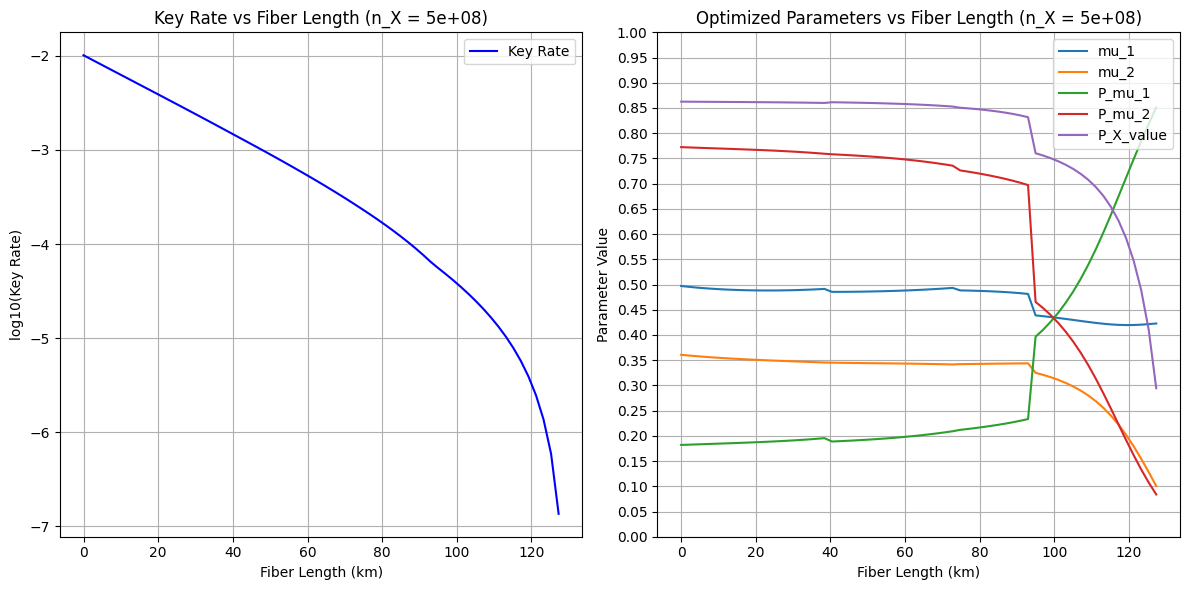

Available n_X values: ['500000000.0']

Plotting results for n_X = 1e+04
No data found for n_X = 10000

Plotting results for n_X = 1e+05
No data found for n_X = 100000

Plotting results for n_X = 1e+06
No data found for n_X = 1000000

Plotting results for n_X = 1e+07
No data found for n_X = 10000000

Plotting results for n_X = 1e+08
No data found for n_X = 100000000

Plotting results for n_X = 1e+09
No data found for n_X = 1000000000


In [19]:
# Load dataset
# with open("qkd_grouped_dataset_20250213_110036.json", 'r') as f:
#     dataset = json.load(f)
with open("reordered_qkd_grouped_dataset_20250224_162146.json", 'r') as f:
    dataset = json.load(f)

plot_for_nx(dataset, 500000000)

# Print available n_X values
print("Available n_X values:", list(dataset.keys())[:5])  # Print first 5 unique n_X values

# List of n_X values to plot
n_X_values = [10**s for s in range(4, 10)]  # Generates [10^4, 10^5, ..., 10^9]

# Loop through n_X values and plot
for n_X in n_X_values:
    print(f"\nPlotting results for n_X = {n_X:.0e}")
    plot_for_nx(dataset, n_X)

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
with open("../../Training_Data/combined_datasets.json", 'r') as f:
    dataset = json.load(f)

# Print available keys (debugging)
print("Available n_X values:", list(dataset.keys()))  

# Define n_X values
n_X_values = [10**s for s in range(4, 10)]  # [10^4, 10^5, ..., 10^9]

# Initialize figure
plt.figure(figsize=(10, 6))

# Plot key rate vs fiber length for each n_X
for n_X in n_X_values:
    target_nx_str = str(float(n_X))  # Ensure correct format

    if target_nx_str not in dataset:
        print(f"❌ No data found for n_X = {n_X}")
        continue

    filtered_data = dataset[target_nx_str]
    filtered_data = [entry for entry in filtered_data if entry["key_rate"] > 1e-30]  

    if not filtered_data:
        print(f"⚠️ No non-zero key rates for n_X = {n_X}")
        continue

    # Extract fiber lengths and key rates
    fiber_lengths = [entry["fiber_length"] for entry in filtered_data]
    key_rates = [entry["key_rate"] for entry in filtered_data]

    # Plot with unique colors and dashed lines
    plt.plot(fiber_lengths, np.log10(key_rates), linestyle='-', label=f"n_X = {n_X:.0e}")

# Graph formatting
plt.xlabel("Fiber Length (km)")
plt.ylabel("log10(Key Rate)")
plt.title("Key Rate vs Fiber Length for Different n_X Values")
plt.legend()
plt.grid(True)

# Save and show plot
plt.savefig("key_rate_vs_fiber_length.png", dpi=300, bbox_inches="tight")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '../../Training_Data/combined_datasets.json'